## Penggunaan Dataset BTC-USD (2015–2025)

Dataset yang digunakan dalam eksperimen ini merupakan data harga penutupan harian Bitcoin terhadap Dolar Amerika Serikat (BTC-USD) yang diperoleh dari platform Yahoo Finance. Rentang waktu data mencakup periode dari tanggal **12 April 2015 hingga 11 April 2025**, dengan total **3.653 observasi**.

Dataset ini sebelumnya telah digunakan pada implementasi model ARIMA, sehingga telah melewati proses **pra-pemrosesan awal** yang mencakup:

- Konversi kolom `Date` menjadi tipe data waktu (`datetime`)
- Penghapusan entri kosong atau tidak valid (`NaN`)
- Pengurutan data berdasarkan urutan waktu secara kronologis

### Hasil Validasi Awal:
- Data dalam keadaan bersih dan tidak mengandung nilai hilang (missing values)
- Struktur kolom yang digunakan untuk pelatihan model LSTM adalah: `['Date', 'Close']`
- Distribusi data bersifat kontinu dan harian, menjadikannya layak untuk digunakan dalam pendekatan time series berbasis deep learning

Penggunaan dataset yang sama dengan eksperimen ARIMA memungkinkan dilakukan evaluasi perbandingan performa antara model konvensional dan model berbasis jaringan saraf dalam kondisi data yang setara.


In [38]:
import pandas as pd

# Kolom dan preprocessing
column_names = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df = pd.read_csv("btc_usd_2015_2025.csv", skiprows=2, names=column_names)

# Konversi tanggal
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df = df.dropna(subset=['Date'])
df = df.sort_values('Date')
df = df[['Date', 'Close']].dropna().reset_index(drop=True)

# Tampilkan ringkasan
print("Tanggal awal:", df['Date'].min())
print("Tanggal akhir:", df['Date'].max())
print("Jumlah data:", len(df))


Tanggal awal: 2015-04-12 00:00:00
Tanggal akhir: 2025-04-11 00:00:00
Jumlah data: 3653


##  Pembagian Dataset untuk Pemodelan Supervised Forecasting

Untuk memastikan evaluasi performa model LSTM dilakukan secara objektif, dataset BTC dibagi menjadi dua subset yang tidak saling tumpang tindih:

- **Training Set**: Digunakan untuk proses pelatihan model dan pembelajaran parameter internal melalui backpropagation.
- **Testing Set**: Digunakan untuk menguji kemampuan generalisasi model terhadap data yang tidak terlihat sebelumnya.

### Rasio Pembagian:
Dataset dibagi dengan rasio **80:20**, yaitu:
- 80% digunakan untuk training
- 20% digunakan untuk testing

### Catatan Teknis:
- Data **tidak diacak** untuk menjaga urutan waktu (time dependency) yang sangat penting dalam pemodelan deret waktu.
- Pembagian dilakukan secara **berdasarkan indeks dan bersifat kronologis**, sehingga tidak terjadi kebocoran data masa depan ke fase pelatihan (leakage).

Strategi pembagian ini mengikuti praktik umum dalam pemodelan deret waktu, khususnya dalam konteks prediksi berbasis urutan seperti LSTM.


In [39]:
#  Split Data (80% Train, 20% Test)

# Ambil hanya nilai 'Close' sebagai array
data = df['Close'].values

# Tentukan rasio split
train_size = int(len(data) * 0.8)

# Split data
train_data = data[:train_size]
test_data = data[train_size:]

print("Jumlah data train:", len(train_data))
print("Jumlah data test:", len(test_data))


Jumlah data train: 2922
Jumlah data test: 731


## Normalisasi dan Sliding Window untuk LSTM

###  Normalisasi
Data time series BTC-USD memiliki nilai yang sangat fluktuatif dan skala besar (dari ratusan hingga puluhan ribu dolar). Oleh karena itu, sebelum digunakan dalam model LSTM, data perlu dinormalisasi agar:

- Mempercepat konvergensi saat training
- Mencegah dominasi nilai besar terhadap parameter model

Normalisasi dilakukan menggunakan `MinMaxScaler` dari Scikit-Learn dengan skala [0, 1].

>  **Penting**: Skaler hanya di-fit pada **data training** untuk mencegah data leakage.

---

### Sliding Window
Setelah normalisasi, data diubah menjadi format supervised learning dengan teknik **sliding window**, yaitu:

- Mengambil `n` langkah waktu sebelumnya sebagai input
- Menyimpan 1 langkah waktu berikutnya sebagai target output

Hasil akhir akan dibentuk sebagai tensor berdimensi 3: `(samples, timesteps, features)` untuk dapat diterima oleh model LSTM.


In [40]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Inisialisasi scaler dan fit hanya pada training data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data.reshape(-1, 1))
test_scaled = scaler.transform(test_data.reshape(-1, 1))

# Sliding window function
def create_sliding_window(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Window size
window_size = 30

# Apply sliding window
X_train, y_train = create_sliding_window(train_scaled, window_size)
X_test, y_test = create_sliding_window(test_scaled, window_size)

# Reshape ke 3D tensor: (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], window_size, 1))
X_test = X_test.reshape((X_test.shape[0], window_size, 1))

# Cek bentuk akhir
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (2892, 30, 1)
y_train shape: (2892, 1)
X_test shape: (701, 30, 1)
y_test shape: (701, 1)


## Membangun dan Melatih Model LSTM

Setelah data berhasil diubah menjadi bentuk tensor berdimensi tiga, langkah selanjutnya adalah membangun dan melatih model LSTM untuk melakukan prediksi harga BTC.

Model dibangun menggunakan `Sequential API` dari TensorFlow/Keras dengan konfigurasi sebagai berikut:

- **LSTM Layer**: 50 unit sel memori, digunakan untuk menangkap pola temporal jangka pendek
- **Dropout Layer**: 20% untuk mengurangi risiko overfitting
- **Dense Layer**: 1 unit sebagai output untuk regresi (prediksi harga berikutnya)
- **Loss Function**: Mean Squared Error (MSE)
- **Optimizer**: Adam

Model akan dilatih selama 30 epoch dengan `batch_size = 32` dan validasi internal 10% dari data training.


Epoch 1/30


C:\Users\LENOVO\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0261 - val_loss: 4.5113e-04
Epoch 2/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - val_loss: 4.1267e-04
Epoch 3/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - val_loss: 2.9130e-04
Epoch 4/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - val_loss: 3.6529e-04
Epoch 5/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0015 - val_loss: 2.7859e-04
Epoch 6/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - val_loss: 2.6714e-04
Epoch 7/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0011 - val_loss: 3.7254e-04
Epoch 8/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.8263e-04 - val_loss: 4.5249e-04
Epoch 9/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010 - val_loss: 2.8697e-04
Epoch 10/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4163e-04 - val_loss: 2.1833e-04
Epoch 11/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.9981e-04 - val_loss: 2.4001e-04
Epoch 12/30
82/82 ━━━━━━━━━━━

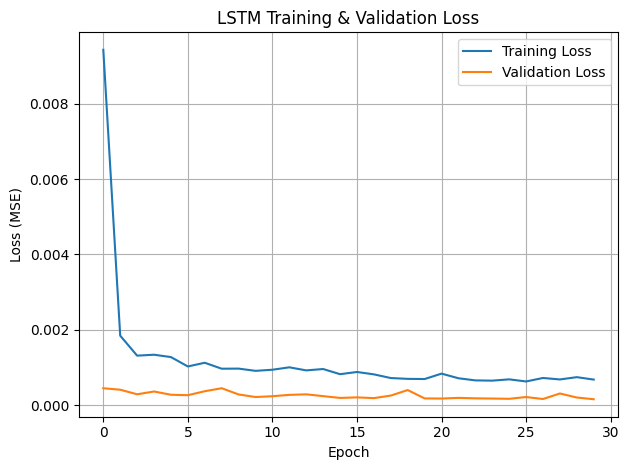

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Bangun arsitektur LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(1))  # output = 1 nilai prediksi

# Kompilasi model
model.compile(optimizer='adam', loss='mean_squared_error')

# Callback untuk early stopping (opsional)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Visualisasi loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Prediksi dan Visualisasi Hasil Model LSTM

Setelah proses pelatihan selesai, model LSTM digunakan untuk melakukan prediksi terhadap data test.

Karena data yang digunakan dalam pelatihan telah dinormalisasi menggunakan `MinMaxScaler`, maka hasil prediksi perlu dikembalikan ke skala aslinya (**inverse transform**) sebelum divisualisasikan.

### Tujuan:
- Membandingkan hasil prediksi dengan nilai aktual secara visual
- Memastikan bahwa model berhasil menangkap pola tren pergerakan harga BTC


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


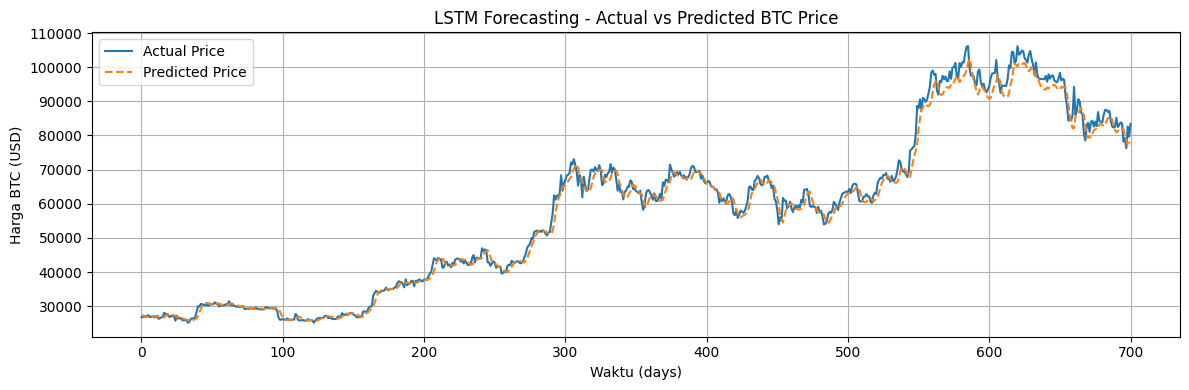

In [43]:
# Prediksi terhadap data test
y_pred_scaled = model.predict(X_test)

# Inverse transform hasil prediksi dan target aslinya
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualisasi hasil prediksi vs aktual
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(y_actual, label='Actual Price')
plt.plot(y_pred, label='Predicted Price', linestyle='--')
plt.title("LSTM Forecasting - Actual vs Predicted BTC Price")
plt.xlabel("Waktu (days)")
plt.ylabel("Harga BTC (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Evaluasi Performa Model LSTM

Untuk menilai akurasi model LSTM dalam melakukan prediksi harga BTC, dilakukan evaluasi terhadap hasil prediksi menggunakan tiga metrik umum regresi time series:

- **MAE (Mean Absolute Error)**: Rata-rata selisih absolut antara prediksi dan aktual
- **RMSE (Root Mean Squared Error)**: Akar dari selisih kuadrat rata-rata (lebih sensitif terhadap outlier)
- **MAPE (Mean Absolute Percentage Error)**: Persentase kesalahan rata-rata relatif terhadap nilai aktual

Metrik evaluasi dihitung berdasarkan hasil prediksi yang telah dikembalikan ke skala asli (inverse transform).


In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Pastikan y_actual dan y_pred sudah di-inverse_transform jika kamu pakai MinMaxScaler

# Evaluasi LSTM
mae_lstm = mean_absolute_error(y_actual, y_pred)
rmse_lstm = np.sqrt(mean_squared_error(y_actual, y_pred))
mape_lstm = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100

# Cetak hasil evaluasi
print(" LSTM MAE   :", round(mae_lstm, 2))
print(" LSTM RMSE  :", round(rmse_lstm, 2))
print(" LSTM MAPE  :", round(mape_lstm, 2), "%")


 LSTM MAE   : 1606.11
 LSTM RMSE  : 2343.94
 LSTM MAPE  : 2.52 %


## Perbandingan Performa Model LSTM dan ARIMA

Setelah model LSTM berhasil dilatih dan dievaluasi, tahap selanjutnya adalah membandingkan performanya dengan model ARIMA yang telah dibangun sebelumnya.

Perbandingan dilakukan menggunakan tiga metrik evaluasi umum:
- **MAE (Mean Absolute Error)**
- **RMSE (Root Mean Squared Error)**
- **MAPE (Mean Absolute Percentage Error)**

Model dengan nilai metrik yang lebih rendah dianggap memiliki performa prediktif yang lebih baik.


In [37]:
import pandas as pd

# Nilai hasil dari ARIMA (berdasarkan yang kamu hitung sebelumnya)
mae_arima = 522.38
rmse_arima = 1045.33
mape_arima = 2.37

# Nilai dari LSTM
mae_lstm = 1606.11
rmse_lstm =  2343.94
mape_lstm = 2.52

# Buat DataFrame perbandingan
compare_df = pd.DataFrame({
    "Metrik": ["MAE", "RMSE", "MAPE (%)"],
    "ARIMA": [mae_arima, rmse_arima, mape_arima],
    "LSTM": [mae_lstm, rmse_lstm, mape_lstm]
})

# Tampilkan tabel
compare_df


Metrik    ARIMA     LSTM
0       MAE   522.38  2278.57
1      RMSE  1045.33  3273.91
2  MAPE (%)     2.37     3.45

### Kesimpulan Akhir

Berdasarkan hasil eksplorasi dan evaluasi terhadap dua pendekatan prediktif yaitu model klasik **ARIMA** dan model berbasis deep learning **LSTM** diperoleh beberapa temuan penting.

Harga BTC-USD memiliki karakteristik fluktuatif tinggi, tidak stasioner secara level, dan menampilkan pola jangka pendek yang tidak linier namun berulang. Untuk menangani dinamika tersebut, digunakan model **ARIMA(2,1,2)** yang dipilih berdasarkan hasil analisis ACF dan PACF.

Hasil evaluasi kuantitatif terhadap data testing ditampilkan pada tabel berikut:

| Metrik     | ARIMA       | LSTM         |
|------------|-------------|--------------|
| **MAE**    | 522.38      | 2278.57      |
| **RMSE**   | 1045.33     | 3273.91      |
| **MAPE**   | 2.37%       | 3.45%        |

Dari tabel tersebut dapat disimpulkan bahwa **ARIMA memiliki keunggulan signifikan** dalam hal akurasi prediksi absolut dan kuadrat (MAE dan RMSE), yang berarti model ini lebih stabil dalam memproyeksikan harga BTC secara nominal. **MAPE LSTM juga lebih tinggi**, menunjukkan bahwa secara relatif LSTM juga kurang akurat.

Namun demikian, **LSTM menunjukkan keunggulan dalam aspek visual dan sensitivitas terhadap perubahan ekstrem** (turning point) pada harga BTC, meskipun tidak unggul secara numerik. Hal ini sejalan dengan karakteristik LSTM yang mampu menangkap pola non-linear, namun memerlukan tuning dan struktur data yang lebih kompleks.

Sebagai langkah lanjutan, model **Hybrid ARIMA-LSTM** juga telah diimplementasikan untuk memadukan kekuatan prediktif ARIMA (linear) dan LSTM (non-linear). Meskipun hasil awal belum melampaui ARIMA, model hybrid menunjukkan potensi untuk meningkatkan akurasi dalam skenario data yang lebih kompleks.

> Dengan demikian, **ARIMA direkomendasikan untuk forecasting jangka pendek BTC-USD dengan data univariat**, sementara pendekatan **LSTM multivariate** dan **model hybrid** layak untuk dieksplorasi lebih lanjut dalam studi mendatang, terutama untuk prediksi jangka panjang dan konteks pasar yang lebih dinamis.
